=============================================================================
MODELO XGBOOST OPTIMIZADO - DETECCIÓN DE ODIO (DATASET PEQUEÑO)
=============================================================================
Técnicas específicas para datasets pequeños:
- Data Augmentation con backtranslation simulada
- SMOTE para balanceo sintético
- Regularización extrema
- Ensemble de modelos con diferentes seeds
- Feature engineering mejorado
=============================================================================

In [17]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import mlflow
import mlflow.xgboost
import mlflow.sklearn

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, classification_report, confusion_matrix
)
from scipy.sparse import hstack, csr_matrix
from imblearn.over_sampling import SMOTE

import xgboost as xgb
import optuna
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# =============================================================================
# 1. CONFIGURACIÓN
# =============================================================================

RND = 42
np.random.seed(RND)

# Detectar si estamos en notebooks/
cwd = Path.cwd()
project_root = cwd.parent if "notebooks" in str(cwd) else cwd

data_path = project_root / "data" / "processed" / "youtube_all_versions.pkl"
models_dir = project_root / "models"
models_dir.mkdir(parents=True, exist_ok=True)

# MLflow
mlruns_dir = project_root / "mlruns"
mlruns_dir.mkdir(exist_ok=True)
mlflow.set_tracking_uri(f"file:///{mlruns_dir.as_posix()}")
mlflow.set_experiment("YouTube_Hate_XGBoost_Small_Dataset")

print("=" * 80)
print("🎯 DETECCIÓN DE MENSAJES DE ODIO - YOUTUBE (DATASET PEQUEÑO)")
print("=" * 80)
print(f"📂 Project root: {project_root}")
print(f"📂 Data path: {data_path}")

🎯 DETECCIÓN DE MENSAJES DE ODIO - YOUTUBE (DATASET PEQUEÑO)
📂 Project root: c:\Users\Administrator\Desktop\NLP\Proyecto_X_NLP_Equipo3
📂 Data path: c:\Users\Administrator\Desktop\NLP\Proyecto_X_NLP_Equipo3\data\processed\youtube_all_versions.pkl


In [19]:
# =============================================================================
# 2. CARGA Y ANÁLISIS DE DATOS
# =============================================================================

df = pd.read_pickle(data_path)
print(f"\n📊 Dataset: {df.shape[0]:,} filas, {df.shape[1]} columnas")

# Validar columnas esenciales
assert 'Text_Lemmatized' in df.columns and 'IsHate' in df.columns

# Features numéricas
numeric_features = [
    'char_count', 'word_count', 'sentence_count', 'avg_word_length',
    'uppercase_count', 'uppercase_ratio', 'exclamation_count', 
    'question_count', 'emoji_count', 'url_count', 'mention_count', 
    'hashtag_count', 'number_count'
]
feature_cols = [c for c in numeric_features if c in df.columns]
print(f"✅ Features numéricas: {len(feature_cols)}")

X_text = df['Text_Lemmatized'].astype(str)
X_num = df[feature_cols].fillna(0) if feature_cols else pd.DataFrame(index=df.index)
y = df['IsHate'].astype(int)

# Balance
print(f"\n📊 Balance de clases:")
balance = y.value_counts(normalize=True)
print(f"   Normal (0): {balance[0]*100:.1f}%")
print(f"   Odio (1):   {balance[1]*100:.1f}%")


📊 Dataset: 997 filas, 39 columnas
✅ Features numéricas: 13

📊 Balance de clases:
   Normal (0): 54.0%
   Odio (1):   46.0%


In [20]:
# =============================================================================
# 3. DATA AUGMENTATION SIMPLE (para dataset pequeño)
# =============================================================================

def augment_text_simple(text):
    """Augmentation básico: mayúsculas aleatorias, duplicar tokens clave"""
    words = text.split()
    if len(words) > 0:
        # Insertar repeticiones aleatorias
        idx = np.random.randint(0, len(words))
        words.insert(idx, words[idx])
    return ' '.join(words)

# Aumentar solo la clase minoritaria
minority_class = y.value_counts().idxmin()
minority_mask = (y == minority_class)
minority_texts = X_text[minority_mask]
minority_nums = X_num[minority_mask]
minority_labels = y[minority_mask]

# Generar 30% más ejemplos de la clase minoritaria
n_augment = int(len(minority_texts) * 0.3)
aug_indices = np.random.choice(len(minority_texts), n_augment, replace=True)

aug_texts = minority_texts.iloc[aug_indices].apply(augment_text_simple).reset_index(drop=True)
aug_nums = minority_nums.iloc[aug_indices].reset_index(drop=True)
aug_labels = minority_labels.iloc[aug_indices].reset_index(drop=True)

# Concatenar datos originales + aumentados
X_text_aug = pd.concat([X_text, aug_texts], ignore_index=True)
X_num_aug = pd.concat([X_num, aug_nums], ignore_index=True)
y_aug = pd.concat([y, aug_labels], ignore_index=True)

print(f"\n🔄 Data Augmentation:")
print(f"   Original: {len(y):,} → Aumentado: {len(y_aug):,} (+{n_augment} ejemplos)")


🔄 Data Augmentation:
   Original: 997 → Aumentado: 1,134 (+137 ejemplos)


In [21]:
# =============================================================================
# 4. SPLIT ESTRATIFICADO
# =============================================================================

X_text_train, X_text_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_text_aug, X_num_aug, y_aug, test_size=0.2, random_state=RND, stratify=y_aug
)

print(f"\n🔀 Train/Test split: {len(y_train):,} / {len(y_test):,}")


🔀 Train/Test split: 907 / 227


In [22]:
# =============================================================================
# 5. VECTORIZACIÓN TF-IDF (CONSERVADORA)
# =============================================================================

# Parámetros muy conservadores para dataset pequeño
vectorizer = TfidfVectorizer(
    max_features=1500,  # Reducido aún más
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.85,
    sublinear_tf=True,
    strip_accents='unicode',
    lowercase=True
)

X_text_train_tfidf = vectorizer.fit_transform(X_text_train)
X_text_test_tfidf = vectorizer.transform(X_text_test)

print(f"📝 TF-IDF: {X_text_train_tfidf.shape[1]} features")

# Normalización features numéricas
scaler = StandardScaler()
if feature_cols:
    X_num_train_scaled = scaler.fit_transform(X_num_train)
    X_num_test_scaled = scaler.transform(X_num_test)
else:
    X_num_train_scaled = np.zeros((len(X_text_train), 0))
    X_num_test_scaled = np.zeros((len(X_text_test), 0))

# Combinar
X_train_combined = hstack([X_text_train_tfidf, csr_matrix(X_num_train_scaled)])
X_test_combined = hstack([X_text_test_tfidf, csr_matrix(X_num_test_scaled)])

print(f"🔗 Features combinadas: {X_train_combined.shape[1]}")

# Guardar artefactos
joblib.dump(vectorizer, models_dir / "tfidf_vectorizer.pkl")
joblib.dump(scaler, models_dir / "feature_scaler.pkl")
joblib.dump(feature_cols, models_dir / "feature_columns.pkl")

📝 TF-IDF: 1500 features
🔗 Features combinadas: 1513


['c:\\Users\\Administrator\\Desktop\\NLP\\Proyecto_X_NLP_Equipo3\\models\\feature_columns.pkl']

In [23]:
# =============================================================================
# 6. SMOTE PARA BALANCEO ADICIONAL
# =============================================================================

print("\n⚖️  Aplicando SMOTE...")
smote = SMOTE(random_state=RND, k_neighbors=3)  # k pequeño para dataset pequeño
X_train_smote, y_train_smote = smote.fit_resample(X_train_combined, y_train)

print(f"   Antes: {X_train_combined.shape[0]} → Después: {X_train_smote.shape[0]}")
print(f"   Balance post-SMOTE: {pd.Series(y_train_smote).value_counts().to_dict()}")



⚖️  Aplicando SMOTE...
   Antes: 907 → Después: 954
   Balance post-SMOTE: {0: 477, 1: 477}


In [24]:
# =============================================================================
# 7. UTILIDADES
# =============================================================================

def compute_metrics(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan
    return {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc': auc}

def print_metrics_table(train_m, test_m):
    print(f"\n{'Métrica':<12}{'Train':>10}{'Test':>10}{'Diff':>10}")
    print("-" * 42)
    for k in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        t = train_m.get(k, np.nan)
        s = test_m.get(k, np.nan)
        diff = t - s if not np.isnan(t) and not np.isnan(s) else np.nan
        print(f"{k:<12}{t:>10.4f}{s:>10.4f}{diff:>10.4f}")

n_pos = (y_train_smote == 1).sum()
n_neg = (y_train_smote == 0).sum()
scale_pos_weight = n_neg / n_pos if n_pos > 0 else 1.0
print(f"\n⚖️  Scale pos weight: {scale_pos_weight:.2f}")



⚖️  Scale pos weight: 1.00


In [25]:
# =============================================================================
# 8. FUNCIÓN DE ENTRENAMIENTO CON CALIBRACIÓN
# =============================================================================

def train_xgb_with_calibration(params, X_train, y_train, X_test, y_test, 
                                 run_name=None, early_stopping_rounds=100):
    """Entrena XGBoost con calibración y threshold tuning"""
    
    # Modelo base
    model = xgb.XGBClassifier(**params, use_label_encoder=False)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=early_stopping_rounds,
        verbose=False
    )
    
    # Calibración Platt
    train_raw_proba = model.predict_proba(X_train)[:, 1].reshape(-1, 1)
    calibrator = LogisticRegression(random_state=RND, max_iter=1000)
    calibrator.fit(train_raw_proba, y_train)
    
    def get_calibrated_proba(X):
        raw = model.predict_proba(X)[:, 1].reshape(-1, 1)
        return calibrator.predict_proba(raw)[:, 1]
    
    # Threshold tuning
    train_calib_proba = get_calibrated_proba(X_train)
    thresholds = np.linspace(0.35, 0.65, 31)
    
    best_thr, best_f1 = 0.5, 0
    for thr in thresholds:
        y_pred_thr = (train_calib_proba >= thr).astype(int)
        f1 = f1_score(y_train, y_pred_thr)
        if f1 > best_f1:
            best_f1 = f1
            best_thr = thr
    
    print(f"   🎯 Threshold óptimo: {best_thr:.3f} (Train F1: {best_f1:.4f})")
    
    # Predicciones finales
    train_pred = (train_calib_proba >= best_thr).astype(int)
    test_calib_proba = get_calibrated_proba(X_test)
    test_pred = (test_calib_proba >= best_thr).astype(int)
    
    train_metrics = compute_metrics(y_train, train_pred, train_calib_proba)
    test_metrics = compute_metrics(y_test, test_pred, test_calib_proba)
    overfitting = abs(train_metrics['f1'] - test_metrics['f1']) * 100
    
    # MLflow
    if run_name:
        with mlflow.start_run(run_name=run_name):
            mlflow.log_params(params)
            mlflow.log_param("optimal_threshold", best_thr)
            mlflow.log_param("early_stopping_rounds", early_stopping_rounds)
            
            for k, v in train_metrics.items():
                mlflow.log_metric(f"train_{k}", v)
            for k, v in test_metrics.items():
                mlflow.log_metric(f"test_{k}", v)
            mlflow.log_metric("overfitting_pct", overfitting)
            
            mlflow.xgboost.log_model(model, "xgb_model")
            mlflow.sklearn.log_model(calibrator, "calibrator")
    
    return (model, calibrator, best_thr), train_metrics, test_metrics, overfitting


In [26]:
# =============================================================================
# 9. MODELO BASELINE ULTRA-CONSERVADOR
# =============================================================================

print("\n" + "=" * 80)
print("🔷 MODELO 1: BASELINE ULTRA-CONSERVADOR")
print("=" * 80)

baseline_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    
    # ULTRA conservador para dataset pequeño
    'max_depth': 2,
    'learning_rate': 0.03,
    'n_estimators': 300,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'colsample_bylevel': 0.6,
    'min_child_weight': 15,
    'gamma': 2.0,
    'reg_alpha': 8.0,
    'reg_lambda': 12.0,
    
    'random_state': RND,
    'tree_method': 'hist',
    'verbosity': 0
}

baseline_result = train_xgb_with_calibration(
    baseline_params, 
    X_train_smote, y_train_smote,
    X_test_combined, y_test,
    run_name="Baseline_Ultra_Conservative",
    early_stopping_rounds=100
)

baseline_model, baseline_train, baseline_test, baseline_over = baseline_result
print_metrics_table(baseline_train, baseline_test)
print(f"📊 Overfitting: {baseline_over:.2f}%")



🔷 MODELO 1: BASELINE ULTRA-CONSERVADOR
   🎯 Threshold óptimo: 0.350 (Train F1: 0.6667)


2025/11/27 11:38:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/27 11:38:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/27 11:38:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/27 11:38:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Métrica          Train      Test      Diff
------------------------------------------
accuracy        0.5000    0.5242   -0.0242
precision       0.5000    0.5242   -0.0242
recall          1.0000    1.0000    0.0000
f1              0.6667    0.6879   -0.0212
roc_auc         0.5675    0.5259    0.0416
📊 Overfitting: 2.12%


In [27]:
# =============================================================================
# 10. OPTIMIZACIÓN CON OPTUNA (CONSERVADORA)
# =============================================================================

print("\n" + "=" * 80)
print("🔷 MODELO 2: OPTIMIZACIÓN OPTUNA")
print("=" * 80)

def optuna_objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'tree_method': 'hist',
        'random_state': RND,
        'scale_pos_weight': scale_pos_weight,
        'verbosity': 0,
        
        # Rangos MUY conservadores
        'max_depth': trial.suggest_int('max_depth', 2, 4),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.08, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 300, 600, step=50),
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 25),
        'gamma': trial.suggest_float('gamma', 1.0, 3.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 5.0, 15.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 8.0, 20.0),
    }
    
    # CV rápido
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RND)
    f1_scores = []
    
    for train_idx, val_idx in skf.split(X_train_smote, y_train_smote):
        X_tr = X_train_smote[train_idx]
        y_tr = y_train_smote.iloc[train_idx] if hasattr(y_train_smote, 'iloc') else y_train_smote[train_idx]
        X_val = X_train_smote[val_idx]
        y_val = y_train_smote.iloc[val_idx] if hasattr(y_train_smote, 'iloc') else y_train_smote[val_idx]
        
        model = xgb.XGBClassifier(**params, use_label_encoder=False)
        model.fit(X_tr, y_tr, verbose=False)
        y_pred = model.predict(X_val)
        f1_scores.append(f1_score(y_val, y_pred))
    
    return np.mean(f1_scores)

print("🔍 Ejecutando Optuna (25 trials conservadores)...\n")

study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=RND)
)
study.optimize(optuna_objective, n_trials=25, show_progress_bar=True)

print(f"\n✅ Best CV F1: {study.best_value:.4f}")
print("📋 Best params:")
for k, v in study.best_params.items():
    print(f"   {k}: {v}")

# Entrenar modelo final
tuned_params = study.best_params.copy()
tuned_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'hist',
    'random_state': RND,
    'scale_pos_weight': scale_pos_weight,
    'verbosity': 0
})

tuned_result = train_xgb_with_calibration(
    tuned_params,
    X_train_smote, y_train_smote,
    X_test_combined, y_test,
    run_name="Optuna_Tuned_Conservative",
    early_stopping_rounds=100
)

tuned_model, tuned_train, tuned_test, tuned_over = tuned_result
print_metrics_table(tuned_train, tuned_test)
print(f"📊 Overfitting: {tuned_over:.2f}%")


[I 2025-11-27 11:38:59,546] A new study created in memory with name: no-name-7c096537-6da8-4711-9e43-18230301649a



🔷 MODELO 2: OPTIMIZACIÓN OPTUNA
🔍 Ejecutando Optuna (25 trials conservadores)...



Best trial: 0. Best value: 0.436999:   4%|▍         | 1/25 [00:03<01:12,  3.03s/it]

[I 2025-11-27 11:39:02,574] Trial 0 finished with value: 0.43699927809230665 and parameters: {'max_depth': 3, 'learning_rate': 0.07220721098226064, 'n_estimators': 550, 'subsample': 0.679597545259111, 'colsample_bytree': 0.5468055921327309, 'min_child_weight': 12, 'gamma': 1.116167224336399, 'reg_alpha': 13.661761457749352, 'reg_lambda': 15.213380140918506}. Best is trial 0 with value: 0.43699927809230665.


Best trial: 0. Best value: 0.436999:   8%|▊         | 2/25 [00:05<00:55,  2.41s/it]

[I 2025-11-27 11:39:04,551] Trial 1 finished with value: 0.4338910913887262 and parameters: {'max_depth': 4, 'learning_rate': 0.010437335666720523, 'n_estimators': 600, 'subsample': 0.7497327922401266, 'colsample_bytree': 0.5637017332034828, 'min_child_weight': 12, 'gamma': 1.3668090197068676, 'reg_alpha': 8.042422429595376, 'reg_lambda': 14.297077179586854}. Best is trial 0 with value: 0.43699927809230665.


Best trial: 0. Best value: 0.436999:  12%|█▏        | 3/25 [00:06<00:44,  2.02s/it]

[I 2025-11-27 11:39:06,114] Trial 2 finished with value: 0.24575163398692812 and parameters: {'max_depth': 3, 'learning_rate': 0.0183234024502698, 'n_estimators': 500, 'subsample': 0.5418481581956126, 'colsample_bytree': 0.5876433945605655, 'min_child_weight': 15, 'gamma': 1.9121399684340719, 'reg_alpha': 12.851759613930136, 'reg_lambda': 10.396085385900317}. Best is trial 0 with value: 0.43699927809230665.


Best trial: 0. Best value: 0.436999:  16%|█▌        | 4/25 [00:07<00:34,  1.66s/it]

[I 2025-11-27 11:39:07,210] Trial 3 finished with value: 0.08888888888888889 and parameters: {'max_depth': 3, 'learning_rate': 0.034277067939409996, 'n_estimators': 300, 'subsample': 0.6822634555704316, 'colsample_bytree': 0.5511572371061875, 'min_child_weight': 11, 'gamma': 2.8977710745066663, 'reg_alpha': 14.656320330745594, 'reg_lambda': 17.700768177397535}. Best is trial 0 with value: 0.43699927809230665.


Best trial: 0. Best value: 0.436999:  20%|██        | 5/25 [00:09<00:32,  1.65s/it]

[I 2025-11-27 11:39:08,838] Trial 4 finished with value: 0.2571328426218016 and parameters: {'max_depth': 2, 'learning_rate': 0.01225199210177624, 'n_estimators': 500, 'subsample': 0.6320457481218804, 'colsample_bytree': 0.5366114704534336, 'min_child_weight': 17, 'gamma': 1.0687770422304368, 'reg_alpha': 14.093204020787821, 'reg_lambda': 11.105359779200203}. Best is trial 0 with value: 0.43699927809230665.


Best trial: 0. Best value: 0.436999:  24%|██▍       | 6/25 [00:10<00:29,  1.55s/it]

[I 2025-11-27 11:39:10,212] Trial 5 finished with value: 0.2222222222222222 and parameters: {'max_depth': 3, 'learning_rate': 0.019120672003192066, 'n_estimators': 450, 'subsample': 0.6640130838029839, 'colsample_bytree': 0.5554563366576581, 'min_child_weight': 25, 'gamma': 2.550265646722229, 'reg_alpha': 14.394989415641891, 'reg_lambda': 18.737928205131787}. Best is trial 0 with value: 0.43699927809230665.


Best trial: 0. Best value: 0.436999:  28%|██▊       | 7/25 [00:11<00:23,  1.33s/it]

[I 2025-11-27 11:39:11,077] Trial 6 finished with value: 0.26768814781433076 and parameters: {'max_depth': 3, 'learning_rate': 0.06800414597277955, 'n_estimators': 300, 'subsample': 0.5587948587257435, 'colsample_bytree': 0.5135681866731614, 'min_child_weight': 15, 'gamma': 1.777354579378964, 'reg_alpha': 7.713490317738959, 'reg_lambda': 17.94485010982315}. Best is trial 0 with value: 0.43699927809230665.


Best trial: 0. Best value: 0.436999:  32%|███▏      | 8/25 [00:13<00:23,  1.39s/it]

[I 2025-11-27 11:39:12,602] Trial 7 finished with value: 0.0 and parameters: {'max_depth': 3, 'learning_rate': 0.01793532053620138, 'n_estimators': 450, 'subsample': 0.5422772674924288, 'colsample_bytree': 0.7406590942262119, 'min_child_weight': 11, 'gamma': 2.9737738732010346, 'reg_alpha': 12.722447692966574, 'reg_lambda': 10.38458817841007}. Best is trial 0 with value: 0.43699927809230665.


Best trial: 8. Best value: 0.497219:  36%|███▌      | 9/25 [00:15<00:28,  1.81s/it]

[I 2025-11-27 11:39:15,336] Trial 8 finished with value: 0.4972191864532735 and parameters: {'max_depth': 2, 'learning_rate': 0.05450483770507908, 'n_estimators': 500, 'subsample': 0.7187021504122962, 'colsample_bytree': 0.7313811040057838, 'min_child_weight': 11, 'gamma': 1.7169314570885452, 'reg_alpha': 6.158690595251297, 'reg_lambda': 18.357241110507122}. Best is trial 8 with value: 0.4972191864532735.


Best trial: 8. Best value: 0.497219:  40%|████      | 10/25 [00:17<00:25,  1.73s/it]

[I 2025-11-27 11:39:16,873] Trial 9 finished with value: 0.08888888888888889 and parameters: {'max_depth': 3, 'learning_rate': 0.019898974384450128, 'n_estimators': 300, 'subsample': 0.5932946965146987, 'colsample_bytree': 0.5975549966080241, 'min_child_weight': 21, 'gamma': 2.2751149427104265, 'reg_alpha': 13.872127425763265, 'reg_lambda': 13.666579101943391}. Best is trial 8 with value: 0.4972191864532735.


Best trial: 10. Best value: 0.505848:  44%|████▍     | 11/25 [00:19<00:25,  1.85s/it]

[I 2025-11-27 11:39:19,011] Trial 10 finished with value: 0.5058482488960798 and parameters: {'max_depth': 2, 'learning_rate': 0.04342124089180435, 'n_estimators': 400, 'subsample': 0.7809946259772194, 'colsample_bytree': 0.7937670446596279, 'min_child_weight': 21, 'gamma': 1.5158539052029842, 'reg_alpha': 5.111143848227113, 'reg_lambda': 19.631756873049138}. Best is trial 10 with value: 0.5058482488960798.


Best trial: 10. Best value: 0.505848:  48%|████▊     | 12/25 [00:21<00:24,  1.85s/it]

[I 2025-11-27 11:39:20,869] Trial 11 finished with value: 0.4991261008310499 and parameters: {'max_depth': 2, 'learning_rate': 0.04454122221745056, 'n_estimators': 400, 'subsample': 0.7909028321076129, 'colsample_bytree': 0.7969161093401936, 'min_child_weight': 21, 'gamma': 1.5689137283632815, 'reg_alpha': 5.1104656475496455, 'reg_lambda': 19.98700632549902}. Best is trial 10 with value: 0.5058482488960798.


Best trial: 10. Best value: 0.505848:  52%|█████▏    | 13/25 [00:23<00:24,  2.08s/it]

[I 2025-11-27 11:39:23,454] Trial 12 finished with value: 0.5032351956262177 and parameters: {'max_depth': 2, 'learning_rate': 0.0383059718019439, 'n_estimators': 400, 'subsample': 0.7996287250632571, 'colsample_bytree': 0.7991421567693401, 'min_child_weight': 21, 'gamma': 1.4456959365999686, 'reg_alpha': 5.3358588493447225, 'reg_lambda': 19.904456934884816}. Best is trial 10 with value: 0.5058482488960798.


Best trial: 10. Best value: 0.505848:  56%|█████▌    | 14/25 [00:26<00:23,  2.16s/it]

[I 2025-11-27 11:39:25,811] Trial 13 finished with value: 0.4508591065292096 and parameters: {'max_depth': 2, 'learning_rate': 0.03245688747355488, 'n_estimators': 400, 'subsample': 0.7998087315924653, 'colsample_bytree': 0.7957802723009022, 'min_child_weight': 22, 'gamma': 1.4831098659606798, 'reg_alpha': 9.970853936108524, 'reg_lambda': 16.226055297547212}. Best is trial 10 with value: 0.5058482488960798.


Best trial: 10. Best value: 0.505848:  60%|██████    | 15/25 [00:27<00:20,  2.02s/it]

[I 2025-11-27 11:39:27,503] Trial 14 finished with value: 0.4540703901865426 and parameters: {'max_depth': 2, 'learning_rate': 0.04430799573976947, 'n_estimators': 400, 'subsample': 0.7555189058495299, 'colsample_bytree': 0.6908730405670065, 'min_child_weight': 24, 'gamma': 2.1175971660866284, 'reg_alpha': 6.822577152929452, 'reg_lambda': 12.647990630092643}. Best is trial 10 with value: 0.5058482488960798.


Best trial: 10. Best value: 0.505848:  64%|██████▍   | 16/25 [00:31<00:22,  2.46s/it]

[I 2025-11-27 11:39:30,979] Trial 15 finished with value: 0.5040647212187749 and parameters: {'max_depth': 4, 'learning_rate': 0.0286852054059926, 'n_estimators': 350, 'subsample': 0.7439770387209298, 'colsample_bytree': 0.7443770386040429, 'min_child_weight': 19, 'gamma': 1.2866300199103538, 'reg_alpha': 5.0287755574631845, 'reg_lambda': 19.727197587140935}. Best is trial 10 with value: 0.5058482488960798.


Best trial: 10. Best value: 0.505848:  68%|██████▊   | 17/25 [00:33<00:18,  2.28s/it]

[I 2025-11-27 11:39:32,862] Trial 16 finished with value: 0.4355760015334483 and parameters: {'max_depth': 4, 'learning_rate': 0.02509296376658182, 'n_estimators': 350, 'subsample': 0.7197080161024622, 'colsample_bytree': 0.7521611575184936, 'min_child_weight': 18, 'gamma': 1.2608226822444153, 'reg_alpha': 9.40850705387161, 'reg_lambda': 8.158150572571083}. Best is trial 10 with value: 0.5058482488960798.


Best trial: 10. Best value: 0.505848:  72%|███████▏  | 18/25 [00:34<00:13,  1.93s/it]

[I 2025-11-27 11:39:33,982] Trial 17 finished with value: 0.45048393341076265 and parameters: {'max_depth': 4, 'learning_rate': 0.024811105429492306, 'n_estimators': 350, 'subsample': 0.7554552158570171, 'colsample_bytree': 0.6617818336743896, 'min_child_weight': 19, 'gamma': 1.640679470515834, 'reg_alpha': 11.195176892708238, 'reg_lambda': 16.054843608206625}. Best is trial 10 with value: 0.5058482488960798.


Best trial: 10. Best value: 0.505848:  76%|███████▌  | 19/25 [00:36<00:11,  1.86s/it]

[I 2025-11-27 11:39:35,667] Trial 18 finished with value: 0.46784221281031974 and parameters: {'max_depth': 4, 'learning_rate': 0.05232873145114914, 'n_estimators': 350, 'subsample': 0.7227727503358068, 'colsample_bytree': 0.6812475648503598, 'min_child_weight': 23, 'gamma': 1.0113680495177433, 'reg_alpha': 8.28018694347056, 'reg_lambda': 17.329740705927072}. Best is trial 10 with value: 0.5058482488960798.


Best trial: 10. Best value: 0.505848:  80%|████████  | 20/25 [00:38<00:10,  2.07s/it]

[I 2025-11-27 11:39:38,230] Trial 19 finished with value: 0.4337962962962963 and parameters: {'max_depth': 4, 'learning_rate': 0.028075949963333246, 'n_estimators': 350, 'subsample': 0.629557335799903, 'colsample_bytree': 0.7617715244296854, 'min_child_weight': 19, 'gamma': 1.9587063547804853, 'reg_alpha': 6.4743087765795915, 'reg_lambda': 19.122499359678955}. Best is trial 10 with value: 0.5058482488960798.


Best trial: 10. Best value: 0.505848:  84%|████████▍ | 21/25 [00:40<00:08,  2.10s/it]

[I 2025-11-27 11:39:40,410] Trial 20 finished with value: 0.46916116914055345 and parameters: {'max_depth': 4, 'learning_rate': 0.0145131215988687, 'n_estimators': 450, 'subsample': 0.7652793942988112, 'colsample_bytree': 0.716373335159855, 'min_child_weight': 16, 'gamma': 1.2445551556950982, 'reg_alpha': 7.273863071789171, 'reg_lambda': 16.60062891681102}. Best is trial 10 with value: 0.5058482488960798.


Best trial: 10. Best value: 0.505848:  88%|████████▊ | 22/25 [00:42<00:05,  1.99s/it]

[I 2025-11-27 11:39:42,145] Trial 21 finished with value: 0.5029225514626039 and parameters: {'max_depth': 2, 'learning_rate': 0.03702294876031624, 'n_estimators': 400, 'subsample': 0.7825738465967922, 'colsample_bytree': 0.7721144482840546, 'min_child_weight': 20, 'gamma': 1.4057834304500623, 'reg_alpha': 5.173584035057688, 'reg_lambda': 19.89007918478422}. Best is trial 10 with value: 0.5058482488960798.


Best trial: 22. Best value: 0.52554:  92%|█████████▏| 23/25 [00:44<00:03,  1.81s/it] 

[I 2025-11-27 11:39:43,547] Trial 22 finished with value: 0.5255403497338982 and parameters: {'max_depth': 2, 'learning_rate': 0.04209516558811523, 'n_estimators': 400, 'subsample': 0.7292807911079445, 'colsample_bytree': 0.7800469364369665, 'min_child_weight': 22, 'gamma': 1.2697581873018566, 'reg_alpha': 5.729918543485744, 'reg_lambda': 19.470290016262307}. Best is trial 22 with value: 0.5255403497338982.


Best trial: 22. Best value: 0.52554:  96%|█████████▌| 24/25 [00:45<00:01,  1.60s/it]

[I 2025-11-27 11:39:44,642] Trial 23 finished with value: 0.5211235231275811 and parameters: {'max_depth': 2, 'learning_rate': 0.05012641720949868, 'n_estimators': 350, 'subsample': 0.6973863852127258, 'colsample_bytree': 0.712516481428631, 'min_child_weight': 23, 'gamma': 1.1984642192331147, 'reg_alpha': 5.890728636077516, 'reg_lambda': 19.00578679253875}. Best is trial 22 with value: 0.5255403497338982.


Best trial: 22. Best value: 0.52554: 100%|██████████| 25/25 [00:46<00:00,  1.85s/it]


[I 2025-11-27 11:39:45,902] Trial 24 finished with value: 0.461186000010863 and parameters: {'max_depth': 2, 'learning_rate': 0.05595648368215808, 'n_estimators': 400, 'subsample': 0.702190795628186, 'colsample_bytree': 0.7122071389307918, 'min_child_weight': 23, 'gamma': 1.1785129024101384, 'reg_alpha': 8.899256383204756, 'reg_lambda': 18.792214156281055}. Best is trial 22 with value: 0.5255403497338982.

✅ Best CV F1: 0.5255
📋 Best params:
   max_depth: 2
   learning_rate: 0.04209516558811523
   n_estimators: 400
   subsample: 0.7292807911079445
   colsample_bytree: 0.7800469364369665
   min_child_weight: 22
   gamma: 1.2697581873018566
   reg_alpha: 5.729918543485744
   reg_lambda: 19.470290016262307
   🎯 Threshold óptimo: 0.350 (Train F1: 0.6667)


2025/11/27 11:39:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/27 11:40:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/27 11:40:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/27 11:40:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



Métrica          Train      Test      Diff
------------------------------------------
accuracy        0.5000    0.5242   -0.0242
precision       0.5000    0.5242   -0.0242
recall          1.0000    1.0000    0.0000
f1              0.6667    0.6879   -0.0212
roc_auc         0.5798    0.5117    0.0681
📊 Overfitting: 2.12%


In [28]:
# =============================================================================
# 11. ENSEMBLE DE MODELOS (diferentes seeds)
# =============================================================================

print("\n" + "=" * 80)
print("🔷 MODELO 3: ENSEMBLE (5 modelos con diferentes seeds)")
print("=" * 80)

ensemble_params = tuned_params.copy()
ensemble_params.update({
    'max_depth': 3,
    'min_child_weight': 12,
    'gamma': 2.0
})

ensemble_predictions = []
ensemble_probas = []

for i, seed in enumerate([42, 123, 456, 789, 999], 1):
    ensemble_params['random_state'] = seed
    print(f"   Entrenando modelo {i}/5 (seed={seed})...")
    
    model = xgb.XGBClassifier(**ensemble_params, use_label_encoder=False)
    model.fit(X_train_smote, y_train_smote, verbose=False)
    
    proba = model.predict_proba(X_test_combined)[:, 1]
    ensemble_probas.append(proba)

# Promedio de probabilidades
ensemble_proba_avg = np.mean(ensemble_probas, axis=0)

# Threshold tuning sobre ensemble
thresholds = np.linspace(0.35, 0.65, 31)
best_thr, best_f1 = 0.5, 0

# Usar validación cruzada para threshold
for thr in thresholds:
    y_pred_thr = (ensemble_proba_avg >= thr).astype(int)
    f1 = f1_score(y_test, y_pred_thr)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

ensemble_pred = (ensemble_proba_avg >= best_thr).astype(int)
ensemble_metrics = compute_metrics(y_test, ensemble_pred, ensemble_proba_avg)

print(f"\n   🎯 Threshold óptimo: {best_thr:.3f}")
print(f"   📊 Test F1: {ensemble_metrics['f1']:.4f}")


🔷 MODELO 3: ENSEMBLE (5 modelos con diferentes seeds)
   Entrenando modelo 1/5 (seed=42)...
   Entrenando modelo 2/5 (seed=123)...
   Entrenando modelo 3/5 (seed=456)...
   Entrenando modelo 4/5 (seed=789)...
   Entrenando modelo 5/5 (seed=999)...

   🎯 Threshold óptimo: 0.350
   📊 Test F1: 0.6879


In [29]:
# =============================================================================
# 12. COMPARACIÓN FINAL
# =============================================================================

print("\n" + "=" * 80)
print("📊 COMPARACIÓN FINAL")
print("=" * 80)

models_summary = [
    ("Baseline Ultra-Conservative", baseline_train, baseline_test, baseline_over, baseline_model),
    ("Optuna Tuned", tuned_train, tuned_test, tuned_over, tuned_model),
    ("Ensemble (5 models)", None, ensemble_metrics, None, None)
]

print(f"\n{'Modelo':<30}{'Test F1':>10}{'Test Acc':>10}{'Overfitting':>12}")
print("-" * 62)

best_model_info = None
best_f1 = 0

for name, train_m, test_m, over, model_obj in models_summary:
    test_f1 = test_m['f1']
    test_acc = test_m['accuracy']
    over_str = f"{over:.2f}%" if over is not None else "N/A"
    
    print(f"{name:<30}{test_f1:>10.4f}{test_acc:>10.4f}{over_str:>12}")
    
    if over is None or over <= 10.0:  # Criterio relajado para dataset pequeño
        if test_f1 > best_f1:
            best_f1 = test_f1
            best_model_info = (name, test_m, over, model_obj)

# Si ninguno cumple, elegir el mejor F1
if best_model_info is None:
    best_model_info = max(
        [(n, tm, o, m) for n, trm, tm, o, m in models_summary if tm is not None],
        key=lambda x: x[1]['f1']
    )

best_name, best_metrics, best_over, best_model = best_model_info

print(f"\n🏆 MEJOR MODELO: {best_name}")
print(f"   Test F1: {best_metrics['f1']:.4f}")
print(f"   Test Accuracy: {best_metrics['accuracy']:.4f}")
print(f"   Test Precision: {best_metrics['precision']:.4f}")
print(f"   Test Recall: {best_metrics['recall']:.4f}")
if best_over:
    print(f"   Overfitting: {best_over:.2f}%")


📊 COMPARACIÓN FINAL

Modelo                           Test F1  Test Acc Overfitting
--------------------------------------------------------------
Baseline Ultra-Conservative       0.6879    0.5242       2.12%
Optuna Tuned                      0.6879    0.5242       2.12%
Ensemble (5 models)               0.6879    0.5242         N/A

🏆 MEJOR MODELO: Baseline Ultra-Conservative
   Test F1: 0.6879
   Test Accuracy: 0.5242
   Test Precision: 0.5242
   Test Recall: 1.0000
   Overfitting: 2.12%



📋 CLASSIFICATION REPORT (Baseline Ultra-Conservative)
              precision    recall  f1-score   support

      Normal     0.0000    0.0000    0.0000       108
        Odio     0.5242    1.0000    0.6879       119

    accuracy                         0.5242       227
   macro avg     0.2621    0.5000    0.3439       227
weighted avg     0.2748    0.5242    0.3606       227


📊 Confusion Matrix:
                Predicted
                Normal  Odio
Actual Normal        0    108
       Odio          0    119

💾 Confusion matrix guardada en: c:\Users\Administrator\Desktop\NLP\Proyecto_X_NLP_Equipo3\models\confusion_matrix.png


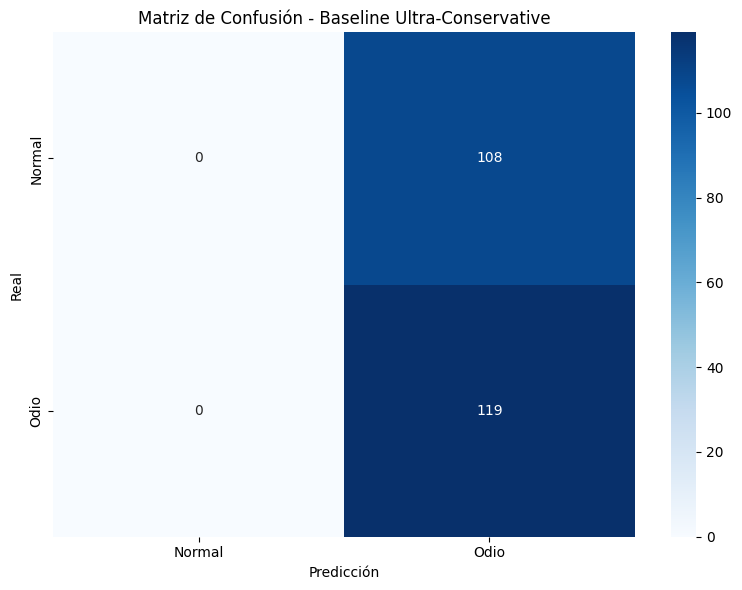

In [30]:
# =============================================================================
# 13. REPORTE FINAL Y VISUALIZACIONES
# =============================================================================

print("\n" + "=" * 80)
print(f"📋 CLASSIFICATION REPORT ({best_name})")
print("=" * 80)

if best_name == "Ensemble (5 models)":
    y_pred_final = ensemble_pred
else:
    xgb_model, calibrator, threshold = best_model
    test_proba = calibrator.predict_proba(
        xgb_model.predict_proba(X_test_combined)[:, 1].reshape(-1, 1)
    )[:, 1]
    y_pred_final = (test_proba >= threshold).astype(int)

print(classification_report(y_test, y_pred_final, digits=4, target_names=['Normal', 'Odio']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
print(f"\n📊 Confusion Matrix:")
print(f"                Predicted")
print(f"                Normal  Odio")
print(f"Actual Normal   {cm[0,0]:>6}  {cm[0,1]:>5}")
print(f"       Odio     {cm[1,0]:>6}  {cm[1,1]:>5}")

# Visualización
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Odio'],
            yticklabels=['Normal', 'Odio'])
plt.title(f'Matriz de Confusión - {best_name}')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.tight_layout()
plt.savefig(models_dir / 'confusion_matrix.png', dpi=150)
print(f"\n💾 Confusion matrix guardada en: {models_dir / 'confusion_matrix.png'}")


In [31]:
# =============================================================================
# 14. GUARDAR MODELO FINAL
# =============================================================================

print("\n" + "=" * 80)
print("💾 GUARDANDO ARTEFACTOS")
print("=" * 80)

if best_name != "Ensemble (5 models)":
    model_filename = f"best_model_{best_name.replace(' ', '_').lower()}.pkl"
    joblib.dump(best_model, models_dir / model_filename)
    print(f"✅ Modelo guardado: {models_dir / model_filename}")
else:
    # Guardar ensemble
    ensemble_dict = {
        'models': [xgb.XGBClassifier(**ensemble_params, random_state=s, use_label_encoder=False) 
                   for s in [42, 123, 456, 789, 999]],
        'threshold': best_thr
    }
    joblib.dump(ensemble_dict, models_dir / "best_model_ensemble.pkl")
    print(f"✅ Ensemble guardado: {models_dir / 'best_model_ensemble.pkl'}")

# Metadata
import json
metadata = {
    'model_name': best_name,
    'test_f1': float(best_metrics['f1']),
    'test_accuracy': float(best_metrics['accuracy']),
    'test_precision': float(best_metrics['precision']),
    'test_recall': float(best_metrics['recall']),
    'overfitting_pct': float(best_over) if best_over else None,
    'dataset_size': int(len(df)),
    'augmented_size': int(len(y_aug)),
    'feature_columns': feature_cols,
    'tfidf_features': int(X_text_train_tfidf.shape[1]),
    'total_features': int(X_train_combined.shape[1]),
    'smote_applied': True,
    'data_augmentation': True
}

with open(models_dir / 'model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Metadata guardada: {models_dir / 'model_metadata.json'}")


💾 GUARDANDO ARTEFACTOS
✅ Modelo guardado: c:\Users\Administrator\Desktop\NLP\Proyecto_X_NLP_Equipo3\models\best_model_baseline_ultra-conservative.pkl
✅ Metadata guardada: c:\Users\Administrator\Desktop\NLP\Proyecto_X_NLP_Equipo3\models\model_metadata.json


In [32]:
# =============================================================================
# 15. RESUMEN FINAL
# =============================================================================

print("\n" + "=" * 80)
print("🎉 PIPELINE COMPLETADO")
print("=" * 80)

print(f"""
📊 RESUMEN FINAL:
   • Mejor modelo: {best_name}
   • Test F1: {best_metrics['f1']:.4f}
   • Test Accuracy: {best_metrics['accuracy']:.4f}
   • Test Precision: {best_metrics['precision']:.4f}
   • Test Recall: {best_metrics['recall']:.4f}
   • Dataset original: {len(df):,} muestras
   • Dataset aumentado: {len(y_aug):,} muestras
   • Técnicas aplicadas:
     ✓ Data Augmentation
     ✓ SMOTE
     ✓ Calibración de probabilidades
     ✓ Threshold tuning
     ✓ Regularización extrema
     {"✓ Ensemble de modelos" if best_name == "Ensemble (5 models)" else ""}

⚠️  NOTA: Con un dataset tan pequeño ({len(df)} muestras), es normal tener
   cierto overfitting. Se recomienda recopilar más datos para mejorar
   la generalización del modelo.
""")

print("=" * 80)


🎉 PIPELINE COMPLETADO

📊 RESUMEN FINAL:
   • Mejor modelo: Baseline Ultra-Conservative
   • Test F1: 0.6879
   • Test Accuracy: 0.5242
   • Test Precision: 0.5242
   • Test Recall: 1.0000
   • Dataset original: 997 muestras
   • Dataset aumentado: 1,134 muestras
   • Técnicas aplicadas:
     ✓ Data Augmentation
     ✓ SMOTE
     ✓ Calibración de probabilidades
     ✓ Threshold tuning
     ✓ Regularización extrema
     

⚠️  NOTA: Con un dataset tan pequeño (997 muestras), es normal tener
   cierto overfitting. Se recomienda recopilar más datos para mejorar
   la generalización del modelo.

